In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path
import csv
import openpyxl

In [13]:
filename='SCMission 2023_Round 3_raw_Data.xlsx'

In [14]:
Cluster = pd.read_excel(filename, sheet_name= 1)
Cluster

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,CustomerRef,CustomerName,SoldToCode,SoldToName,MajorAccount,MajorAccountCode,MajorAccountCode.1,Channel,SubChannel,Longitude,Latitude,City,State,Country,SalesOrganization,Region
0,1000125,Customer 1,4002351,Company 1,Export,92468.0,92345.0,Export,Export,100.777442,13.746792,Bangkok,Thailand,Thailand,Organization 2,NaN
1,1000343,Customer 2,4002351,Company 1,Export,92468.0,92345.0,Export,Export,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001879,Customer 3,4002351,Company 1,Export,92468.0,92345.0,Export,Export,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001880,Customer 4,4002351,Company 1,Export,92468.0,92345.0,Export,Export,121.471181,31.233623,Shanghai,China,China,Organization 2,NaN
4,1002325,Customer 5,4002351,Company 1,Export,92468.0,92345.0,Export,Export,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,2011528,Customer 857,12000426,NaN,Account 99,92471.0,92348.0,Domestic,Other,145.156241,-38.094313,Frankston,Victoria,Australia,NaN,Greater Melbourne
855,2007503,Customer 856,2007501,NaN,Export,NaN,NaN,Export,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,4014549,Customer 774,14017621,Company 414,Account 18,91413.0,91290.0,Grocery,Supermarkets,145.136628,-37.952852,Kingston,Victoria,Australia,NaN,Greater Melbourne
857,4004674,Customer 858,4010314,NaN,Export,NaN,NaN,Export,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
Cluster = pd.DataFrame(Cluster)

Thông qua dữ liệu được hiển thị ở trên, các cụm có thể được phân chia dựa vào các trường có giá trị lớn như:
Channel, State, Country,... Đặc biệt, trong dữ liệu cho sẵn có toạ độ địa lý của khách hàng, cho nên có thể dựa vào 
thuật toán KMeans để phân cụm dựa vào vị trí của các khách hàng gần nhau.

In [26]:
for x in ['Channel', 'Country']:
    print(Cluster[x].value_counts())
    print()

Channel
Foodservice    405
Domestic       213
Export         161
Grocery         80
Name: count, dtype: int64

Country
Australia               696
Thailand                 13
Japan                    10
Singapore                 8
China                     8
Malaysia                  6
Philippines               6
Vietnam                   4
Indonesia                 3
United Arab Emirates      2
Korea                     2
Hong Kong                 2
France                    1
Papua New Guinea          1
New Zealand               1
Saudi Arabia              1
Taiwan                    1
Mexico                    1
Tasmania                  1
Name: count, dtype: int64



Dựa vào thống kê ở trên, ta thấy được sản phẩn của công ty chủ yếu cung cấp cho thị trường trong nước, số lượng khách hàng ngoài nữa khá ít. 
Cho nên ta có thể phân thành 2 cụm lớn: Trong nước và xuất khẩu. 


Đầu tiên, ta sẽ phân chia các cụm nhỏ xuất khẩu. Ở đây, có hai hướng để phân chia:
- Thứ nhất, chúng ta có thể phân chia dựa theo khu vực trên thế giới (theo tên nước)
- Thứ hai, chúng ta sử dụng KMeans để phân chia các cụm gần nhau.

1. Phân chia theo khu vực
Trong dữ liệu đã cho, có một số lượng nhỏ các khách hàng xuất khẩu nhưng không có tên nước, ta sẽ thêm một một cụm "Khác".
   - Đông Nam Á
   - Đông Á
   - Khác (Bao gồm các nước không ở trong hai khu vực trên và không có tên nước)

In [31]:
Cluster_Australia = pd.DataFrame(Cluster[Cluster["Country"] == "Australia"])
Cluster_NAustralia = pd.DataFrame(Cluster[Cluster["Country"] != "Australia"])     


In [43]:
SoutheastAsia = Cluster[Cluster['Country'].isin(SA)]
EastAsia = Cluster[Cluster["Country"].isin(EA)]

In [46]:
df = pd.DataFrame(Cluster_Australia)

In [47]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

In [48]:
world = gpd.read_file("ne_10m_admin_0_countries.shp")
australia = world[world['SOVEREIGNT']=='Australia']
states = gpd.read_file("ne_10m_admin_1_states_provinces.shp")
australian_states = states[states['admin'] == 'Australia']

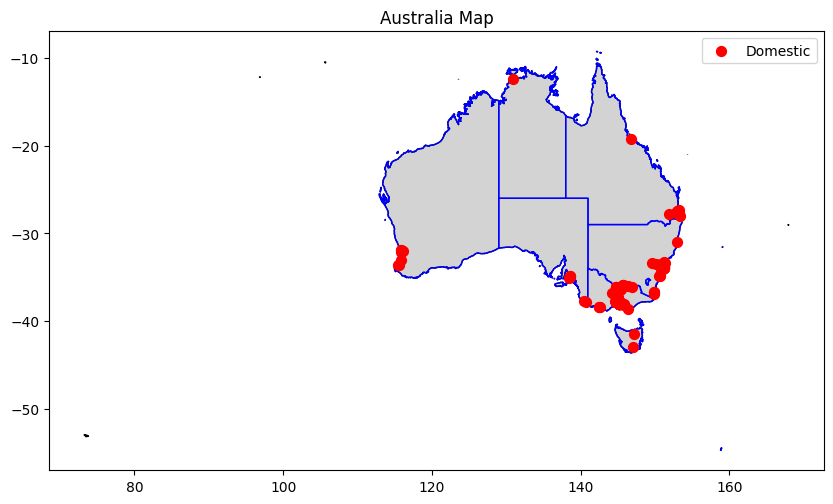

In [50]:
# Tạo subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Vẽ bản đồ của Australia
australia.plot(ax=ax, color='lightgray', edgecolor='black')
#Hien thi dia gioi cac bang
australian_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)
# Vẽ các thành phố lớn
gdf_dom = gdf[gdf['Channel']=="Domestic"] 
gdf_fs = gdf[gdf["Channel"] == "Foodservice"]
gdf_gro = gdf[gdf['Channel'] == "Grocery"]

ax.scatter(gdf_dom['geometry'].x, gdf_dom['geometry'].y, color='red', s=50, label='Domestic')

# Đặt tên cho subplot
ax.set_title('Australia Map')
ax.legend()
# Hiển thị bản đồ
plt.show()

In [53]:
help(gdf_dom)

Help on GeoDataFrame in module geopandas.geodataframe object:

class GeoDataFrame(geopandas.base.GeoPandasBase, pandas.core.frame.DataFrame)
 |  GeoDataFrame(data=None, *args, geometry=None, crs=None, **kwargs)
 |  
 |  A GeoDataFrame object is a pandas.DataFrame that has a column
 |  with geometry. In addition to the standard DataFrame constructor arguments,
 |  GeoDataFrame also accepts the following keyword arguments:
 |  
 |  Parameters
 |  ----------
 |  crs : value (optional)
 |      Coordinate Reference System of the geometry objects. Can be anything accepted by
 |      :meth:`pyproj.CRS.from_user_input() <pyproj.crs.CRS.from_user_input>`,
 |      such as an authority string (eg "EPSG:4326") or a WKT string.
 |  geometry : str or array (optional)
 |      If str, column to use as geometry. If array, will be set as 'geometry'
 |      column on GeoDataFrame.
 |  
 |  Examples
 |  --------
 |  Constructing GeoDataFrame from a dictionary.
 |  
 |  >>> from shapely.geometry import Poi

In [70]:
gdf_dom.value_counts("State")

State
Victoria              125
New South Wales        45
Queensland             24
Western Australia       8
South Australia         6
Tasmania                2
Northern Territory      1
Name: count, dtype: int64

In [78]:
locations = np.array([gdf_dom['geometry'].x, gdf_dom['geometry'].y])
kmeans = KMeans(n_clusters = 2)
kmeans.fit(locations)
cluster_labels = kmeans.predict(locations)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


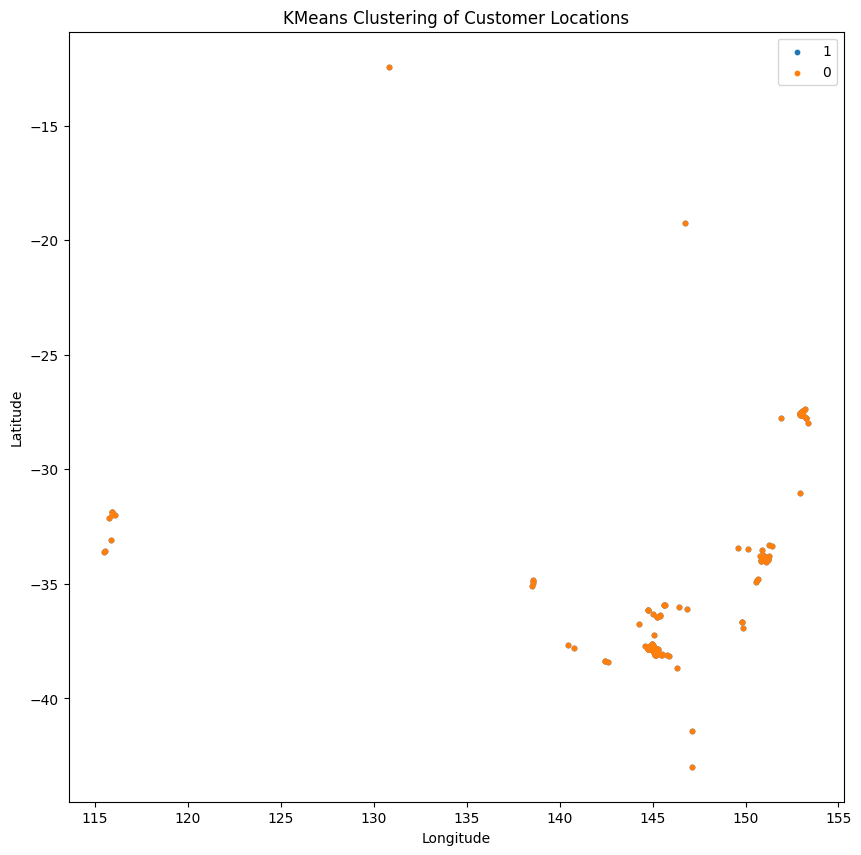

In [81]:
cluster_labels = table['cluster_labels'].unique()
plt.figure(figsize=(10, 10))
for cluster_label in cluster_labels:
    plt.scatter(gdf_dom['Longitude'],gdf_dom['Latitude'],
                 label=cluster_label,
                 s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering of Customer Locations')
plt.legend()
plt.show()

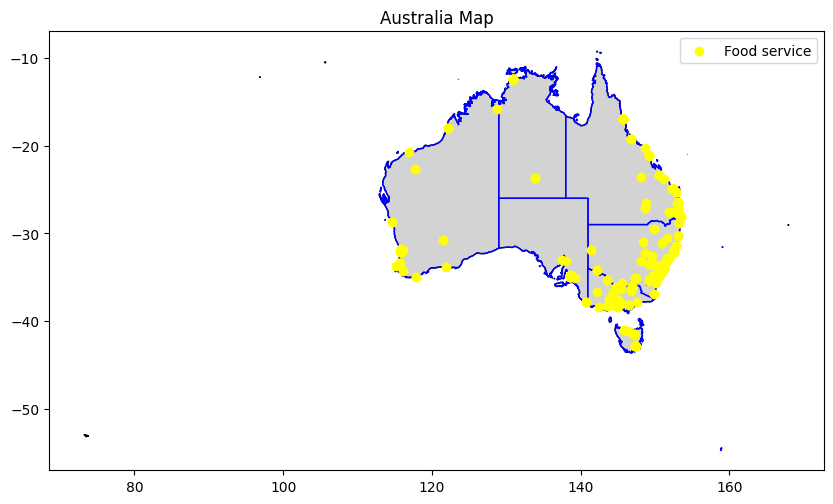

In [50]:
# Tạo subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Vẽ bản đồ của Australia
australia.plot(ax=ax, color='lightgray', edgecolor='black')
#Hien thi dia gioi cac bang
australian_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)

ax.scatter(df_fs['geometry'].x, df_fs['geometry'].y, color='yellow', label = "Food service")

# Đặt tên cho subplot
ax.set_title('Australia Map')
ax.legend()
# Hiển thị bản đồ
plt.show()

In [53]:
df_fs.value_counts("State")

State
New South Wales                 114
Victoria                         96
Queensland                       87
Western Australia                51
South Australia                  29
Tasmania                         13
Northern Territory               10
Australian Capital Territory      5
Name: count, dtype: int64

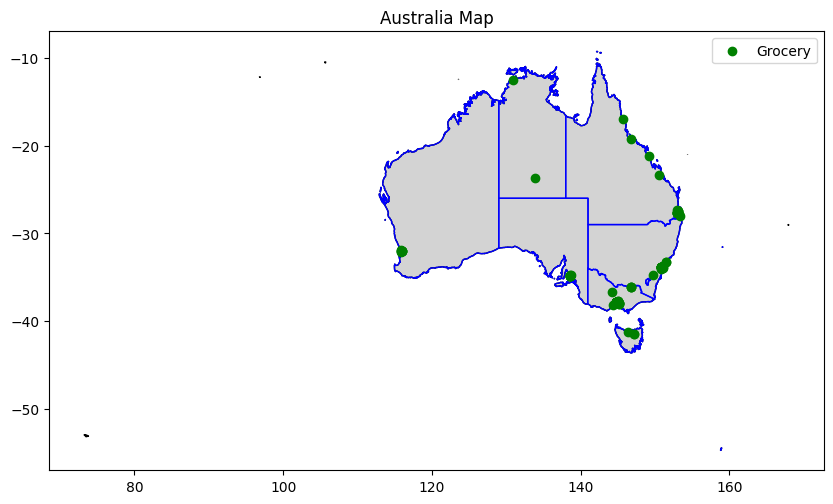

In [51]:
# Tạo subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Vẽ bản đồ của Australia
australia.plot(ax=ax, color='lightgray', edgecolor='black')
#Hien thi dia gioi cac bang
australian_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)

ax.scatter(df_gro['geometry'].x, df_gro['geometry'].y, color='green', label = "Grocery")

# Đặt tên cho subplot
ax.set_title('Australia Map')
ax.legend()
# Hiển thị bản đồ
plt.show()

In [55]:
df_gro.value_counts("State")


State
Victoria              23
New South Wales       18
Queensland            18
South Australia        8
Western Australia      8
Tasmania               3
Northern Territory     2
Name: count, dtype: int64

In [44]:
from sklearn.cluster import KMeans